 **Let's go from here onwards.**

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 23.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=8fdf829f6d8d57c2f8d689ceca8d603d93cd0ef89a40273651da7d7e0d7a782f
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import findspark
import time
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark
sc= spark.sparkContext.getOrCreate()

In [ ]:
inp = pd.read_csv('input(1).csv')
inp2 = inp.drop('3.634701031374295326e+02', axis=1)
inp2.to_csv('data.csv')

In [ ]:
import pandas as pd
from pyspark.sql.types import FloatType

from pyspark.sql.functions import col


dataSet = spark.read.csv('data.csv')
dataSet_rename = dataSet.withColumnRenamed("_c1","x") \
    .withColumnRenamed("_c2","y")
dataSet_rename = dataSet_rename.drop(col("_c0"))
dataSet_rename = dataSet_rename.withColumn("x", col("x").cast(FloatType()))
dataSet_rename = dataSet_rename.withColumn("y", col("y").cast(FloatType()))

dataSet_rename = dataSet_rename.na.drop("any", subset =["x", "y"])
dataSet_rename = dataSet_rename.drop('y')
dataSet_rename = dataSet_rename.withColumnRenamed("x", "features")
dataSet_rename.show(5,True)

+---------+
| features|
+---------+
| 302.8296|
| 277.9614|
| 352.1543|
|241.94319|
|173.03511|
+---------+
only showing top 5 rows



In [ ]:
from scipy.spatial import distance
import numpy as np
data_array =  np.array(dataSet_rename.select("x","y").collect())
print (len(data_array))
flag = True ;

AnalysisException: ignored

In [ ]:
#Calculates the Straight line distance between two points
from scipy.spatial import distance
def calculate_distance(x,y):
 return distance.euclidean(x,y);

In [ ]:
from pyspark.ml.linalg import Vectors
# Define the mapper function to assign each data point to the nearest centroid
def mapper(point, centroids):
    point_array = np.array(point)
    distances = np.linalg.norm(point_array - centroids, axis=1)
    nearest_centroid = np.argmin(distances)
    return (nearest_centroid, point)

# Define the reducer function to compute the new centroid for each cluster
def reducer(points):
    points_array = np.array(points)
    centroid = np.mean(points_array, axis=0)
    return centroid.tolist()

# Define the function to map and reduce the data
def mapperReducer(data, centroids):
    mapped = data.rdd.map(lambda row: mapper(row["features"], centroids))
    reduced = mapped.groupByKey().mapValues(lambda points: reducer(list(points)))
    return reduced

# Define the function to find the new centroids for each cluster
def findNewCentroids(mappedData):
    new_centroids = []
    for centroid in mappedData.collect():
        new_centroids.append(centroid[1])
    return new_centroids

# Generate some random data
np.random.seed(0)
data = [(Vectors.dense(np.random.randn(2) * 100 + [350, 350]),) for i in range(10000)]
dataSet = spark.createDataFrame(data, ["features"])

# Initialize the centroids
centroidPoints = np.array([[100, 100], [50, 50], [150, 150], [250, 250], [350, 350], [450, 450], [200, 200], [300, 300], [400, 400], [270, 270], [380, 380], [480, 480], [230, 230], [90, 90], [170, 170]])
start_time = time.time()
# Iterate for a fixed number of times
for i in range(16):
    # Map each data point to the nearest centroid and compute the new centroids
    mappedData = mapperReducer(dataSet, centroidPoints)
    centroidPoints = findNewCentroids(mappedData)
    print("New Centroids after iteration", i+1, ":", centroidPoints)
end_time = time.time()
print('the time for K-means clustering with MapReduce is:'+ str(end_time - start_time))

New Centroids after iteration 1 : [[406.87218562715174, 405.573195056153], [374.582130896021, 380.174980112374], [346.3579630362684, 344.05761112484805], [204.4536321920992, 199.5082059776226], [225.13219725894032, 232.951520121833], [182.03016086747718, 162.6893191055099], [158.52182998903743, 136.32407444787307], [145.35660670055083, 82.256202405082], [442.1342127958273, 441.9379841541792], [495.8094295199946, 494.36241366904494], [303.8974910686558, 308.1835474026719], [250.00842961504856, 251.54211111445608], [269.08753779222417, 276.9728495241468], [156.94333385193826, 14.391819349065088]]
New Centroids after iteration 2 : [[439.3108617809854, 445.89675061403494], [428.3377994129325, 383.30948980095127], [371.01878910488574, 318.0833050389707], [243.1053395860451, 309.41872604471905], [300.26256471082354, 317.3337372615447], [176.05790345961591, 282.05278119613297], [117.19727837346588, 172.44353298500693], [500.2323655190289, 494.777516527164], [338.85578658743293, 413.7860001880

In [ ]:
from pyspark.ml.linalg import Vectors
# Define the mapper function to assign each data point to the nearest centroid
def mapper(point, centroids):
    point_array = np.array(point)
    distances = np.linalg.norm(point_array - centroids, axis=1)
    nearest_centroid = np.argmin(distances)
    return (nearest_centroid, point)

# Define the reducer function to compute the new centroid for each cluster
def reducer(points):
    points_array = np.array(points)
    centroid = np.mean(points_array, axis=0)
    return centroid.tolist()

# Define the function to map and reduce the data
def mapperReducer(data, centroids):
    mapped = data.rdd.map(lambda row: mapper(row["features"], centroids))
    reduced = mapped.groupByKey().mapValues(lambda points: reducer(list(points)))
    return reduced

# Define the function to find the new centroids for each cluster
def findNewCentroids(mappedData):
    new_centroids = []
    for centroid in mappedData.collect():
        new_centroids.append(centroid[1])
    return new_centroids

# Generate some random data
np.random.seed(0)
# data = [(Vectors.dense(np.concatenate((np.random.normal(350, 100, size=2) * 10, np.array([40, 40]).reshape(1, 2))), axis=0),) for i in range(100)]
# data = [(Vectors.dense(np.concatenate((np.random.normal(350, 100, size=2) * 10, np.array([40, 40]).reshape(1, 2))), axis=0)),) for i in range(100)]
dataSet = spark.createDataFrame(data, ["features"])

# Initialize the centroids
centroidPoints = np.array([[30, 30], [50, 50]])

# Iterate for a fixed number of times
for i in range(10):
    # Map each data point to the nearest centroid and compute the new centroids
    mappedData = mapperReducer(dataSet, centroidPoints)
    centroidPoints = findNewCentroids(mappedData)
    print("New Centroids after iteration", i+1, ":", centroidPoints)

ValueError: ignored

In [ ]:
#MapReduce function for K-means clustering
def mapperReducer(data, centroidPoints):
 mappedData = data.rdd.map(lambda x: ([calculate_distance(x, centroidPoints[i]) for i in range(k)], x)).map(lambda x : (x[0].index(min(x[0])), (x[1],1)))
 reducedData= mappedData.reduceByKey(lambda x, y: ((x[0][0]+y[0][0],x[0][1]+y[0][1] ), x[1]+y[1]));
 meanXY = reducedData.map(lambda x: (x[0], (x[1][0][0]/x[1][1], x[1][0][1]/x[1][1])));
 sort_meanXY = meanXY.sortByKey(ascending=True).values().collect();
 return (sort_meanXY);

In [ ]:
#Finds the new centroids
def findNewCentroids(data):
  newCentroidPoints= [];
  for i in data:
    newCentroidPoints.append([i[0],i[1]]);
  return newCentroidPoints; 

In [ ]:
#To form random centroids for the first iteration.
vectors = [np.array(point) for point in data_array]
parallelVectors = sc.parallelize(vectors)
parallelVectors.cache()
k =15 #Number of clusters
# You can set the iteration
iteration = 30;
centroidPoints =parallelVectors.takeSample(False, k)
print (centroidPoints)

[array([350.54388428, 211.48728943]), array([340.98727417, 433.23873901]), array([461.45797729, 248.49481201]), array([484.8692627 , 409.13101196]), array([250.3633728 , 486.76760864]), array([592.96984863, 312.0640564 ]), array([358.65557861, 260.23562622]), array([216.69358826, 212.56707764]), array([408.81295776, 380.7571106 ]), array([372.17971802, 323.13861084]), array([227.80245972, 401.47137451]), array([355.86056519, 354.5418396 ]), array([151.70559692, 152.29545593]), array([261.53131104, 403.8548584 ]), array([413.55630493, 415.7767334 ])]


In [ ]:
# Iteration for K-means CLustering
start_time = time.time()
for i in range(iteration):
#  mappedData = mapperReducer(dataSet_rename, centroidPoints);
#  centroidPoints = [];
#  centroidPoints = findNewCentroids(mappedData);
#  print ("New Centroids after iteration",i+1,":" ,centroidPoints)

  dataSet_shuffle = dataSet_rename.rdd.randomSplit([1]*dataSet_rename.count())
  dataSet_rename = spark.createDataFrame(dataSet_shuffle[0], schema=dataSet_rename.schema)
    
  mappedData = mapperReducer(dataSet_rename, centroidPoints)
  centroidPoints = findNewCentroids(mappedData)
  print("New Centroids after iteration", i+1, ":", centroidPoints)
end_time = time.time()

print('Time for MapReduce clustering is:' + str(end_time - start_time))

New Centroids after iteration 1 : [[359.3236389160156, 365.9207458496094]]


Py4JJavaError: ignored

In [ ]:
#Cluster assignment to each data point after "n" number of iteration
clusterAssigment = clusterAssigment1= dataSet_rename.rdd.map(lambda x: ([calculate_distance(x, centroidPoints[i]) for i in range(k)], x)).map(lambda x : (x[0].index(min(x[0])), x[1]));
clusterAssigment.take(5)
clusterAssigment.saveAsTextFile("resultsClusterAssignment.csv")
#Now refresh. You will see the csv file in the files section in the left side of the window.

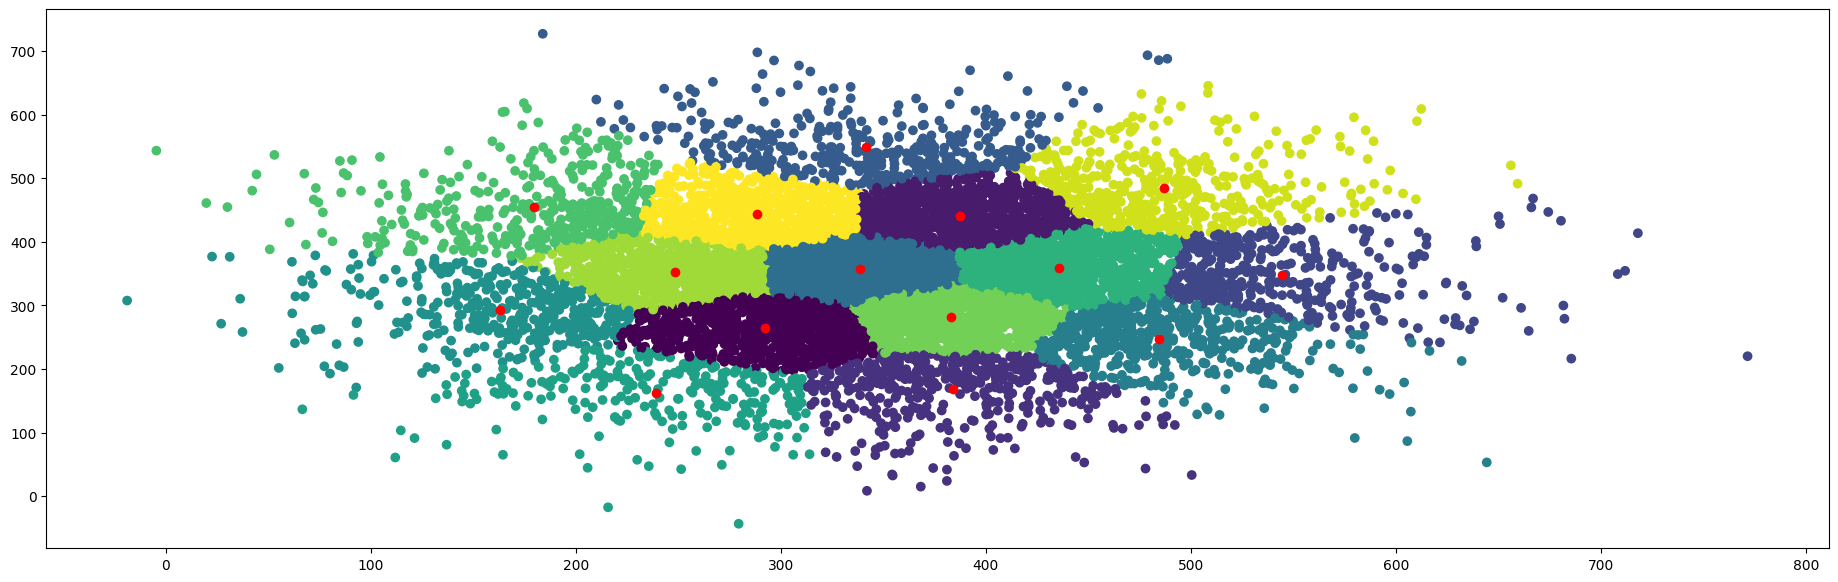

In [ ]:
#Scatter plot - Run this to generate scatter plot
data = np.array(clusterAssigment.map(lambda x: x[1]).collect());
clusters = np.array(clusterAssigment1.map(lambda x: x[0]).collect());
import matplotlib.pyplot as plt
plt.figure(figsize=(23,7))
plt.scatter(data[:,0],data[:,1], c=clusters)
for i in range(k):
 plt.scatter(centroidPoints[i][0] ,centroidPoints[i][1], color='red')

**implementing k-means on the dataset**

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans

# Load data into a Pandas DataFrame
data = pd.read_csv('input(1).csv')

# Select columns to use for clustering
X = data[['3.028295805343384473e+02', '1.698422579742361052e+02']]

# Choose number of clusters
n_clusters = 15

# Fit KMeans model to data
start_time = time.time()
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter = 30).fit(X)
end_time = time.time()

# Get cluster assignments for each data point
labels = kmeans.labels_

# Add cluster assignments to original data
data['cluster'] = labels


print('the time for regular k-means clustering is:'+ str(end_time - start_time))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


the time for regular k-means clustering is:2.3071742057800293


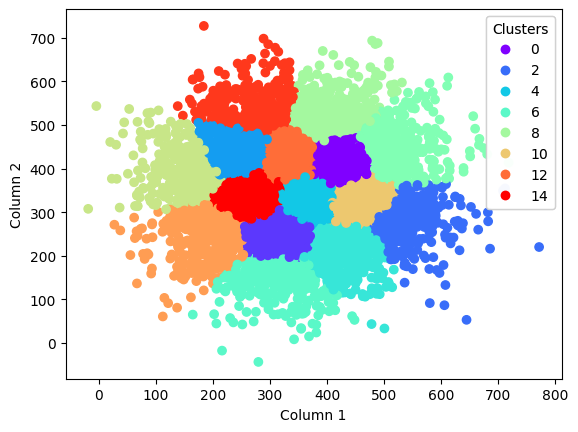

In [ ]:
import matplotlib.pyplot as plt
# Plot the clusters
fig, ax = plt.subplots()
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='rainbow')
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend)
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.show()

In [ ]:
from pyspark.sql.functions import rand
n = 5

# Calculate fraction of rows for each sample
fraction = 1.0 / n

# Randomly split DataFrame into n samples
samples = dataSet_rename.orderBy(rand()).randomSplit([fraction] * n, seed=42)

samples[0].show(5,True)

+---------+---------+
|        x|        y|
+---------+---------+
| 36.39755|310.37866|
|61.783676|287.43082|
| 63.32537|314.20395|
| 67.92086|314.07635|
| 76.36271|  413.932|
+---------+---------+
only showing top 5 rows



In [ ]:
centroidPoints_= []
for i in range(n):
  sample_i = samples[i]
  vectors = [np.array(point) for point in data_array]
  parallelVectors = sc.parallelize(vectors)
  parallelVectors.cache()
  k =15 #Number of clusters
  # You can set the iteration
  iteration = 30;
  centroidPoints =parallelVectors.takeSample(False, k)
  for i in range(iteration):
    mappedData = mapperReducer(sample_i, centroidPoints);
    centroidPoints = [];
    centroidPoints = findNewCentroids(mappedData);
    # print ("New Centroids after iteration",i+1,":" ,centroidPoints)
  centroidPoints_.append(centroidPoints)
  print(centroidPoints_)

[[[332.8744179220761, 147.33949471922483], [498.7828822209285, 421.6380685659555], [280.1078170776367, 430.69847653037624], [434.689485042467, 318.85653392546766], [281.16125657101895, 331.86380394468915], [443.64405553481157, 209.79520094628427], [242.26465288798013, 222.83132163683572], [376.30818671422287, 469.96980922269506], [374.91984244115946, 373.1347470059722], [349.9220938431589, 268.1801165530556], [173.79025177728562, 418.10116213843935], [278.3695965391217, 565.7105190392697], [464.6766668047224, 542.6947773524693], [540.7895307444563, 304.0987454809324], [174.4899849024686, 298.8770006353205]]]
[[[332.8744179220761, 147.33949471922483], [498.7828822209285, 421.6380685659555], [280.1078170776367, 430.69847653037624], [434.689485042467, 318.85653392546766], [281.16125657101895, 331.86380394468915], [443.64405553481157, 209.79520094628427], [242.26465288798013, 222.83132163683572], [376.30818671422287, 469.96980922269506], [374.91984244115946, 373.1347470059722], [349.922093

In [ ]:
""